In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [15., 10.]

Read image into 2D numpy array

In [3]:
# read image into standard 2-d numpy array
hdu_1 = fits.open("./MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
#print(hdu_1.info())
data = hdu_1[1].data

# Need to do byteswap operation because astropy.io.fits returns big-endian
# byte order arrays, even on little-endian machines. 
data = data.astype(data.dtype.newbyteorder('='))
print(np.shape(data))

#print(np.nanmin(data))
#print(np.nanmax(data))
#print(data[0:500,0:500])
#plt.plot(data[500])
#plt.show()

(8582, 14339)


In [4]:
def rescale_image(data,vmin=0.5,vmax=100):
    data_tmp = data.copy()

    # find the mean of the data, excluding NaN
    m = np.nanmean(data_tmp)

    # set cutoffs using vmin/vmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # scale using log base 10
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [5]:
# scale the data and take care of NaN
data = rescale_image(data,vmin=0.5,vmax=100)
#print(np.min(data))
#print(np.max(data))

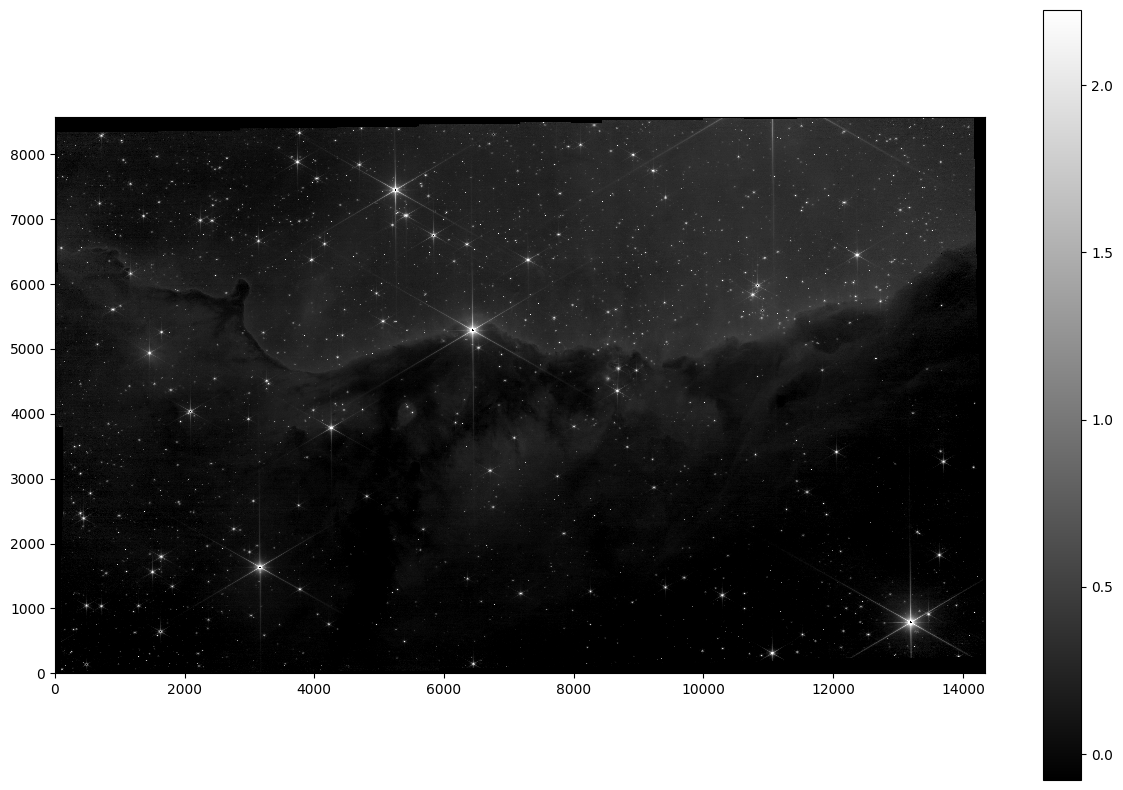

In [6]:
# show the image
# use nanmean and nanstd to ignore nan while seeing the image
#m, s = np.nanmean(data), np.nanstd(data)
#plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.imshow(data, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324GrayImage.png')

In [7]:
# measure a spatially varying background on the image
#bkg = sep.Background(data)
#bkg = sep.Background(data, mask=None, bw=256, bh=256, fw=3, fh=3)
bkg = sep.Background(data, mask=None, bw=256, bh=256)

In [8]:
print(bkg.globalback)
print(bkg.globalrms)

0.06524530798196793
0.024211300536990166


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

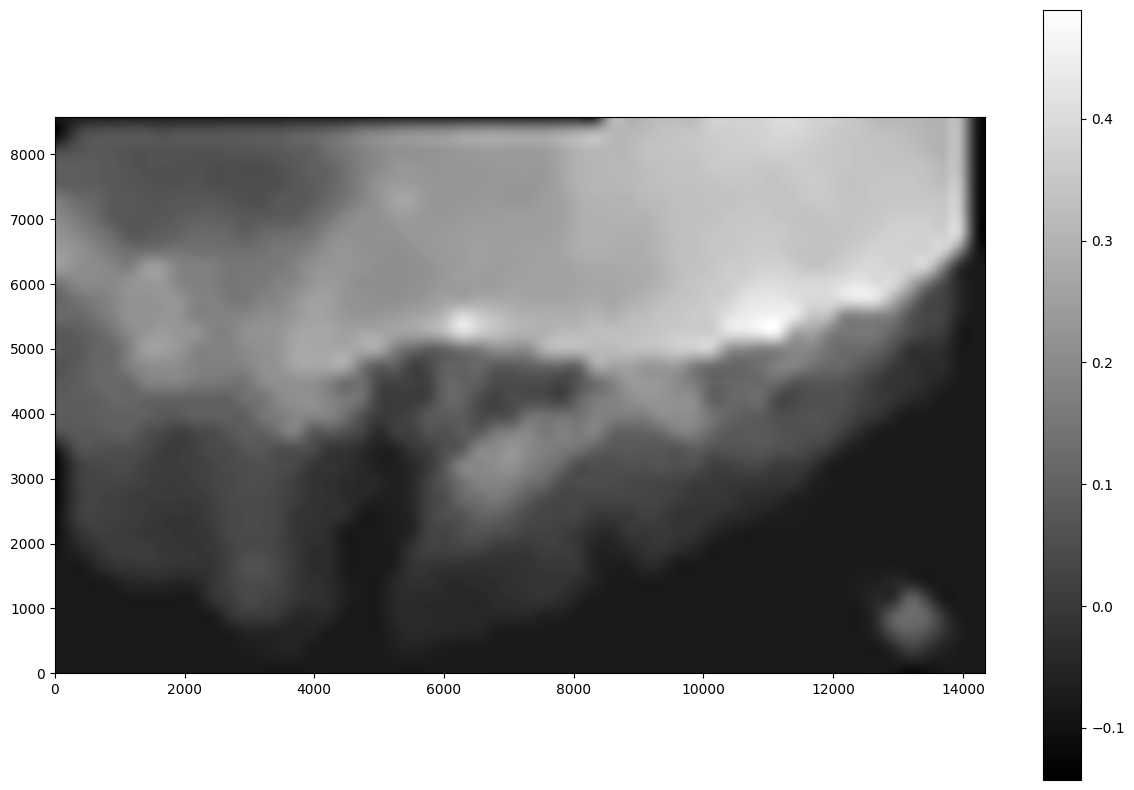

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324Background.png')

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

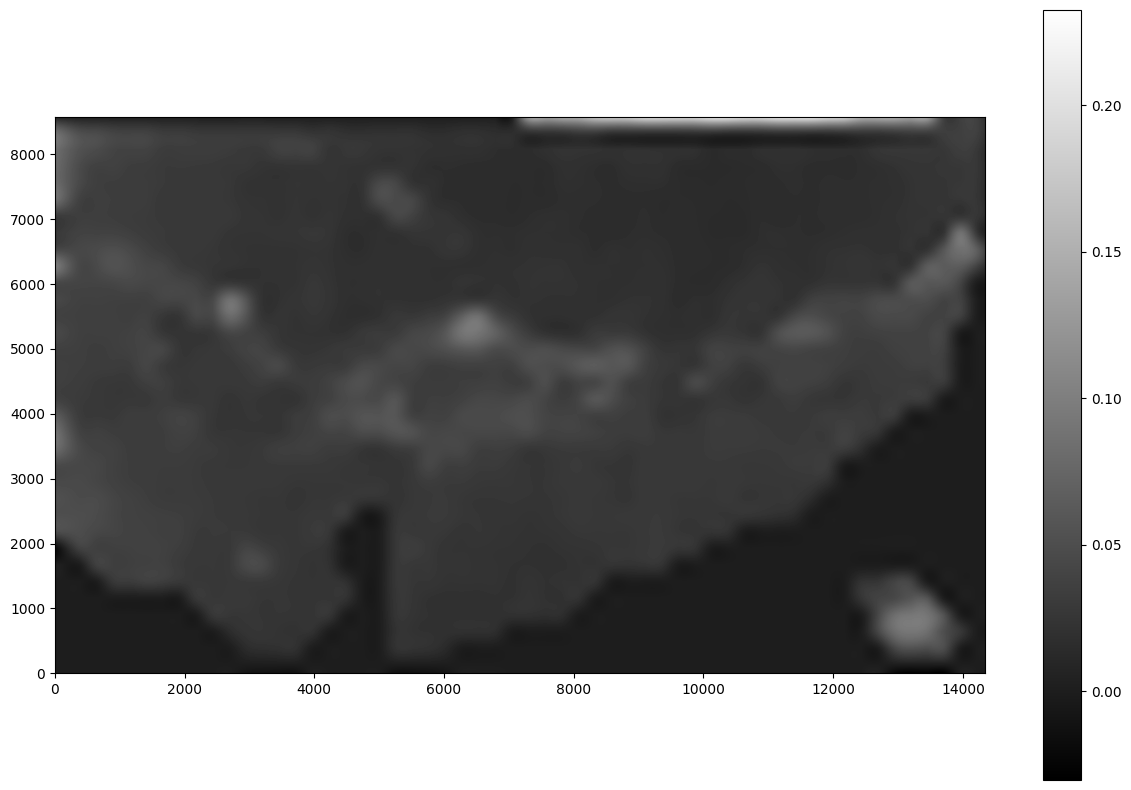

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324BackgroundNoise.png')

In [13]:
#subtract the background
data_sub = data - bkg

In [14]:
objects = sep.extract(data_sub, 50, err=bkg.globalrms)

In [15]:
# how many objects were detected
print(f'Detected {len(objects)} objects')

Detected 2209 objects


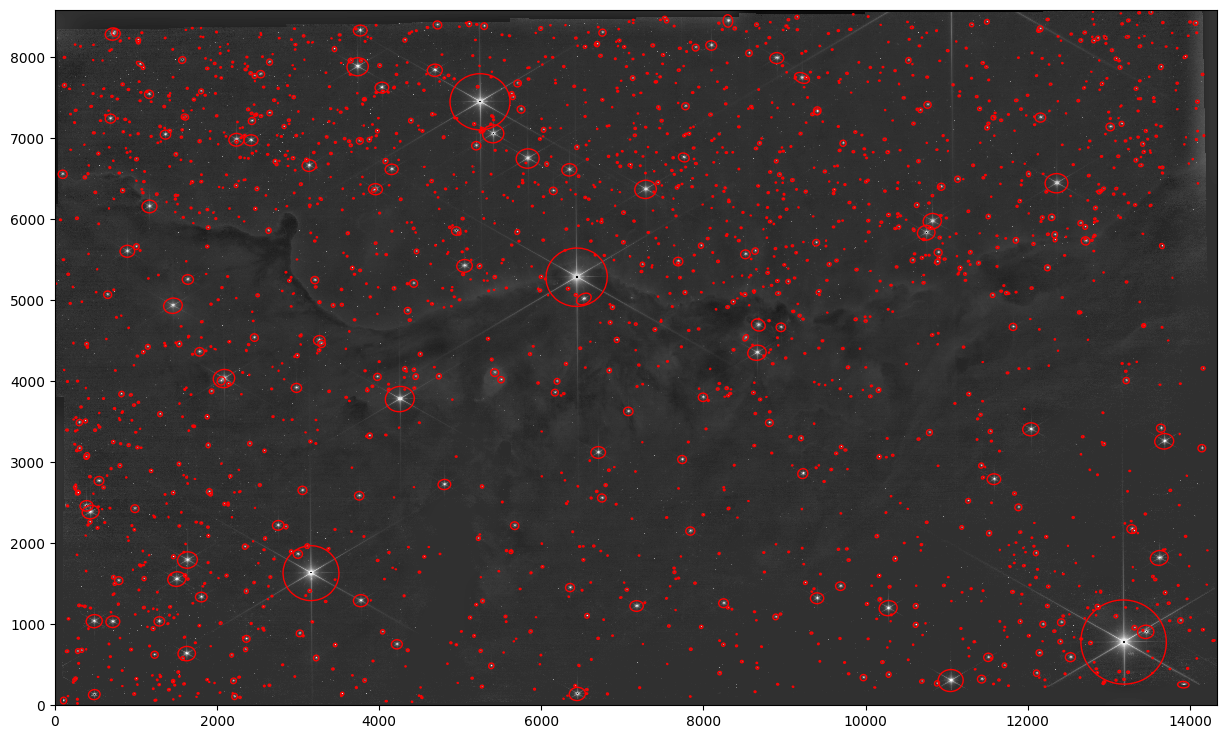

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
#im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#               vmin=m-s, vmax=m+s, origin='lower')
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=20*objects['a'][i],
                height=20*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('NGC3324IdenitifiedObjects.png')

In [17]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [19]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 33.901964 +/- 5.823965
object 1: flux = 31.547637 +/- 5.618208
object 2: flux = 37.718353 +/- 6.142871
object 3: flux = 34.979818 +/- 5.915779
object 4: flux = 41.592323 +/- 6.450496
object 5: flux = 54.218162 +/- 7.364419
object 6: flux = 27.418488 +/- 5.237849
object 7: flux = 39.668952 +/- 6.299651
object 8: flux = 27.389524 +/- 5.235081
object 9: flux = 40.761994 +/- 6.385810


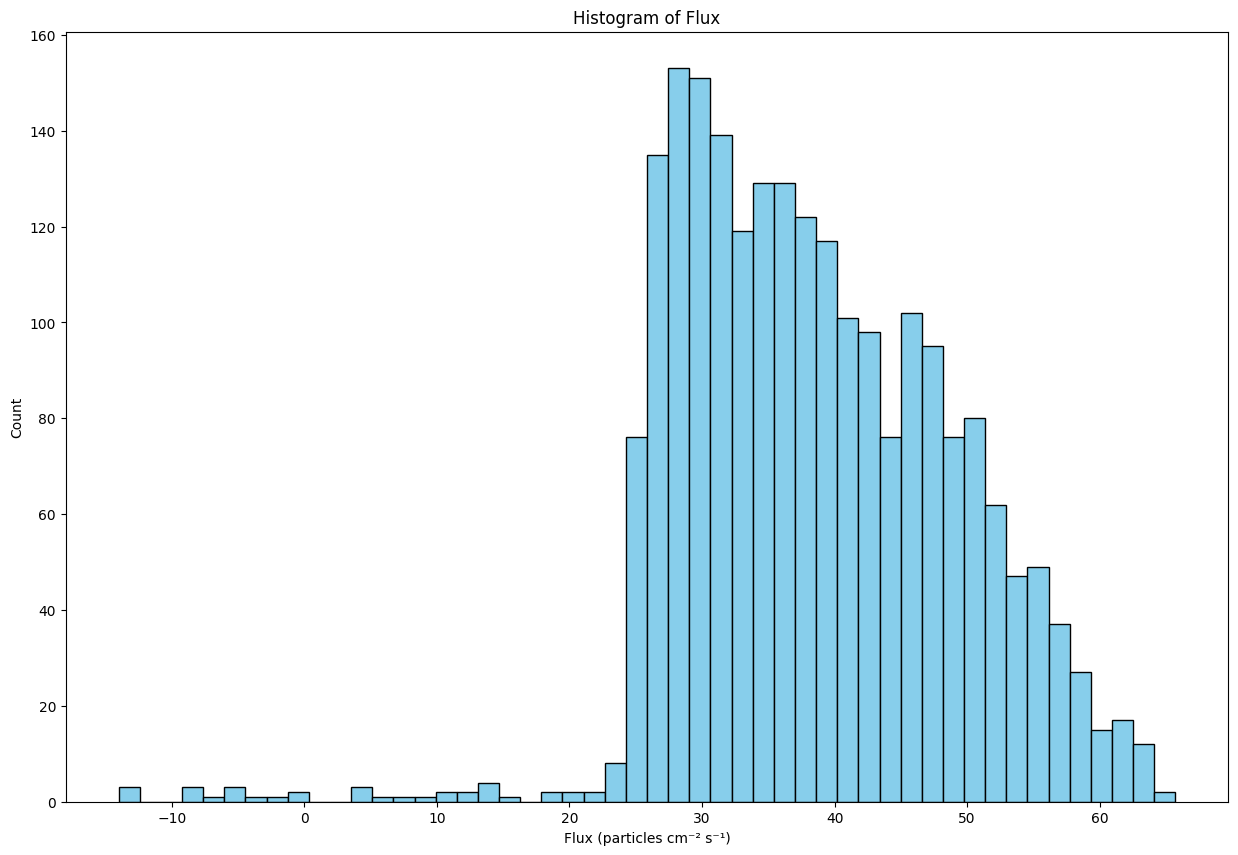

In [20]:
## Part 6: Show histograms of flux
bins = 50
plt.hist(flux, bins=bins, edgecolor='black', color='skyblue')
plt.xlabel('Flux (particles cm⁻² s⁻¹)')
plt.ylabel('Count')
plt.title("Histogram of Flux")
plt.savefig('NGC3324FluxHistogram.pdf', bbox_inches='tight', dpi=600)

In [21]:
## Part 7: mean, median, and standard deviation of the distribution of fluxes
meanFlux = np.mean(flux)
stdFlux = np.std(flux)
print(f"Mean of flux values: {meanFlux:.2f}")
print(f"Standard deviation of flux values: {stdFlux:.2f}")
minFlux = np.min(flux)
maxFlux = np.max(flux)
if np.abs(minFlux - meanFlux) > np.abs(maxFlux - meanFlux):
    largestOutlier = minFlux
else:
    largestOutlier = maxFlux
print(f"Largest outlier flux in terms of deviation from mean: {largestOutlier:.2f}")
print(f"Largest outlier flux is {np.abs(largestOutlier-meanFlux)/stdFlux:.2f} standard deviations from mean")

Mean of flux values: 38.45
Standard deviation of flux values: 10.45
Largest outlier flux in terms of deviation from mean: -14.01
Largest outlier flux is 5.02 standard deviations from mean


In [22]:
## ################################
# Beginning of reproject script
# ---------------------------------
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

'''
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
# Specify path to clear-f090w fits file
file_reference = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname2 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname3 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname4 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname5 = 'MAST/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        orig_data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (orig_data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")
# End of reproject script
## ################################
'''
print('Commenting because I already generated the reprojected files which I just load')

Commenting because I already generated the reprojected files which I just load


(8582, 14339, 3)
(8582, 14339, 3)


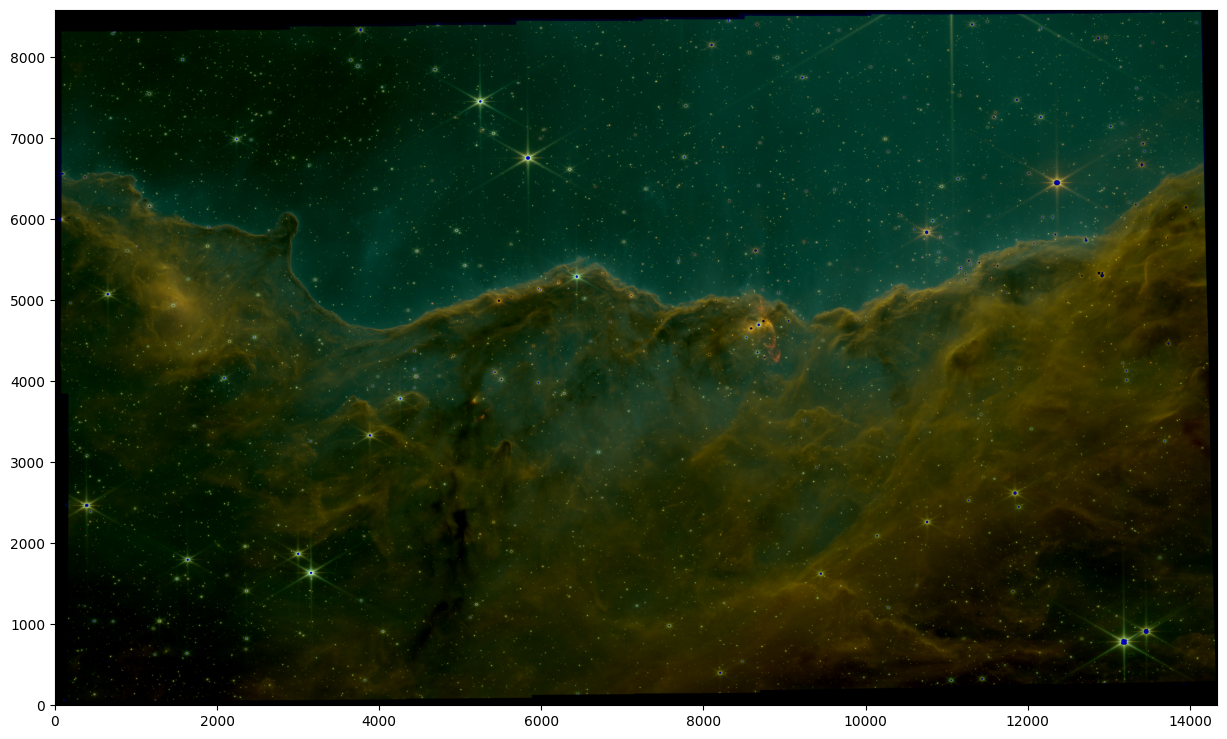

In [23]:
# Now, load the reprojected images

reproj_fname1 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname2 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname3 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname4 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname5 = 'MAST/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]

hdu1 = fits.open(reproj_fname1)
hdu2 = fits.open(reproj_fname2)
hdu3 = fits.open(reproj_fname3)
hdu4 = fits.open(reproj_fname4)
hdu5 = fits.open(reproj_fname5)

data1 = hdu1['SCI'].data
data2 = hdu2['SCI'].data
data3 = hdu3['SCI'].data
data4 = hdu4['SCI'].data
data5 = hdu5['SCI'].data

data_all = np.zeros((data.shape[0], data.shape[1], 3))
data_all[:,:,2] = data + 0.5*data1
#data_all[:,:,1] = 0.5*data1
data_all[:,:,1] = data2 + 0.5*data1 + 0.5*data3 + 0.647*data4
#data_all[:,:,3] = data3
#data_all[:,:,4] = data4
data_all[:,:,0] = data5 + data4 + 0.5*data3


data_all_res = rescale_image(data_all)
print(np.shape(data_all_res))


def remap(data):
    # copy the data to avoid accidently overwriting it
    data_tmp = data.copy()
    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax - dmin)


## TO FIX: Create the final rgb image using all six images
## Right now, we are just using the first three images as the R, G, and B components of the final image

rgb_image = remap(data_all_res[:,:,0:3])
print(np.shape(rgb_image))

plt.imshow(rgb_image, origin='lower')
plt.savefig('NGC3324RGBImage.png')
plt.show()